In [12]:
import tensorflow as tf
from tensorflow.keras import  datasets,layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import sklearn
from sklearn.model_selection import train_test_split
from skimage.feature import hog

# **Visualtion and loading of dataset**

In [13]:
(x_train,y_train), (x_test,y_test) = datasets.cifar10.load_data()

In [14]:
# using only 2 percent of the dataset just to train and test the model
fraction_to_keep = 0.02

# Split the data into train and validation sets while keeping the specified fraction
x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=1 - fraction_to_keep, random_state=42)
x_test, _, y_test, _ = train_test_split(x_test, y_test, test_size=1 - fraction_to_keep, random_state=42)



In [15]:
print(x_train.shape)
print(x_test.shape)

(1000, 32, 32, 3)
(200, 32, 32, 3)


In [16]:
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)
y_train[:5]

array([3, 4, 1, 8, 4], dtype=uint8)

In [17]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [18]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

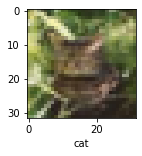

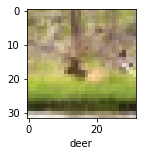

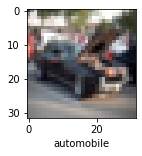

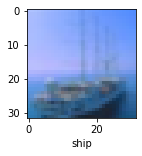

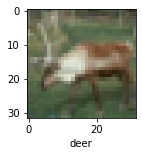

In [19]:
for i in range(5):
    plot_sample(x_train,y_train,i)

# **Extracting the sift feartures and correspoding lable for the testing data**

In [20]:
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

sift_features = []
labels = []

for i in range(x_train.shape[0]):
    image = x_train[i]
    label = y_train[i]  # Get the label corresponding to the current image

    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    features = extract_sift_features(image)

    # Check if there are any SIFT features before appending
    if features is not None:
        sift_features.append(features)
        # Append the corresponding label for each descriptor
        labels.extend([label] * features.shape[0])

if sift_features:
    sift_features = np.vstack(sift_features)
    labels = np.array(labels)


In [21]:
print(sift_features.shape)
print(labels.shape)

(12926, 128)
(12926,)


In [22]:
# genrating the sift features for testing data
features = []
lables = []
for i in range(x_test.shape[0]):
    img = x_test[i]
    lable = y_test[i]
    if img.shape[2]==3 and len(img.shape)==3:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ft= extract_sift_features(img)
    if ft is not None:
        features.append(ft)
        lables.extend([lable]*ft.shape[0])
if features:
    test_features = np.vstack(features)
    test_lables = np.array(lables)

# **Traning the SVM classifier**

In [23]:
from sklearn import svm

clf = svm.SVC()

clf.fit(sift_features, labels)


SVC()

In [24]:
pred = clf.predict(test_features)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
accuracy = accuracy_score(test_lables,pred)
precision = precision_score(test_lables,pred,average='weighted')
recall = recall_score(test_lables,pred,average = 'weighted')
f1 = f1_score(test_lables, pred,average = 'weighted')
cm = confusion_matrix(test_lables,pred)

In [26]:
# Printing the metrics
print("Accuracy:", accuracy*100,"%")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 17.27810650887574 %
Precision: 0.1872998029498483
Recall: 0.1727810650887574
F1 Score: 0.16692201659064948


# **Classification Using HOG**

In [27]:
def extract_hog_features(image):
    features, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    return features

hog_features = []
labels = []

for i in range(x_train.shape[0]):
    image = x_train[i]
    label = y_train[i]  

    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculating  HOG features
    features = extract_hog_features(image)

    # Checking if there are any HOG features befor# Get the label corresponding to the current imagee appending
    if len(features) > 0:
        hog_features.append(features)
        # Appending the corresponding label for each descriptor
        labels.append(label)

if hog_features:
    hog_features = np.vstack(hog_features)
    labels = np.array(labels)


In [28]:
# genrating hog features and lables for tetsing data
test_features=[]
test_lables=[]
for i in range(x_test.shape[0]):
    img = x_test[i]
    label = y_test[i]
    if len(img.shape)==3 and img.shape[2]==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = extract_hog_features(img)
    if len(features)>0:
        test_features.append(features)
        test_lables.append(label)
if test_features:
    test_features=np.vstack(test_features)
    test_lables = np.array(test_lables)

In [29]:
print(hog_features.shape)
print(labels.shape)
print(test_features.shape)
print(test_lables.shape)

(1000, 324)
(1000,)
(200, 324)
(200,)


# **SVM Training Using HOG Features**

In [30]:
clf = svm.SVC()
clf.fit(hog_features,labels)

SVC()

In [31]:
preds = clf.predict(test_features)

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
accuracy = accuracy_score(test_lables,preds)
precision = precision_score(test_lables,preds,average='weighted')
recall = recall_score(test_lables,preds,average = 'weighted')
f1 = f1_score(test_lables, preds,average = 'weighted')
cm = confusion_matrix(test_lables,preds)

In [33]:
# Printing the metrics
print("Accuracy:", accuracy*100,"%")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 47.0 %
Precision: 0.49788634071242766
Recall: 0.47
F1 Score: 0.4703919205154073


# **Question 2**

In [34]:
def calculate_lbp(image):
    lbp_image = np.zeros(image.shape, dtype=np.uint8)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            center = image[i, j]
            code = 0
            code |= (image[i - 1, j - 1] >= center) << 7
            code |= (image[i - 1, j] >= center) << 6
            code |= (image[i - 1, j + 1] >= center) << 5
            code |= (image[i, j + 1] >= center) << 4
            code |= (image[i + 1, j + 1] >= center) << 3
            code |= (image[i + 1, j] >= center) << 2
            code |= (image[i + 1, j - 1] >= center) << 1
            code |= (image[i, j - 1] >= center) << 0
            lbp_image[i, j] = code
    return lbp_image

In [35]:
# extracting the lbp features of each image from the training dataset 
lbp_image = []
for i in range(x_train.shape[0]):
    img = x_train[i]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = calculate_lbp(img)
    lbp_image.append(img)
lbp_image_xtrain = np.array(lbp_image)

In [36]:
# extracting the lbp features of each image from the testing dataset 
lbp_image = []
for i in range(x_test.shape[0]):
    img = x_test[i]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = calculate_lbp(img)
    lbp_image.append(img)
lbp_image_xtest = np.array(lbp_image)

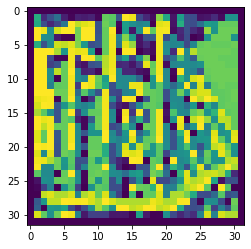

In [37]:
plt.imshow(lbp_image[0])

In [38]:
print(lbp_image_xtrain.shape)
print(x_train.shape)

(1000, 32, 32)
(1000, 32, 32, 3)


In [57]:
# Extracting the testing and Training Sift features
sift_ft_train = []
sift_ft_test = []
trainlables = []
testlables = []
for i in range (lbp_image_xtrain.shape[0]):
    img = lbp_image_xtrain[i]
    lable = y_train[i]
    img = extract_sift_features(img)
    if img is not None:
        sift_ft_train.append(img)
        trainlables.extend([lable]*len(img))
if sift_ft_train:
    sift_ft_train = np.vstack(sift_ft_train)
    trainlables = np.array(trainlables)

for i in range (lbp_image_xtest.shape[0]):
    img = lbp_image_xtest[i]
    lable = y_test[i]
    img = extract_sift_features(img)
    if img is not None:
        sift_ft_test.append(img)
        testlables.extend([lable]*len(img))
if sift_ft_test:
    sift_ft_test = np.vstack(sift_ft_test)
    testlables = np.array(testlables)

In [60]:
print(sift_ft_train.shape)
print(trainlables.shape)
print(sift_ft_test.shape)
print(testlables.shape)

(15352, 128)
(15352,)
(2994, 128)
(2994,)


In [61]:
# training and pridiction of the feature using svm
clf = svm.SVC()
clf.fit(sift_ft_train,trainlables)
preds = clf.predict(sift_ft_test)

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
accuracy = accuracy_score(testlables,preds)
precision = precision_score(testlables,preds,average='weighted')
recall = recall_score(testlables,preds,average = 'weighted')
f1 = f1_score(testlables, preds,average = 'weighted')
cm = confusion_matrix(testlables,preds)

# Printing the metrics
print("Accuracy:", accuracy*100,"%")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 14.529058116232466 %
Precision: 0.15895013058559618
Recall: 0.14529058116232466
F1 Score: 0.14000013172091835


In [1]:
print(f"Image shape: {img.shape}")


NameError: name 'img' is not defined

In [80]:
# Extracting the testing and Training hog features
hog_ft_train = []
hog_ft_test = []
hogtrainlables = []
hogtestlables = []

for i in range(lbp_image_xtrain.shape[0]):
    img = lbp_image_xtrain[i]
    label = y_train[i]
    # if len(img.shape)==3 and img.shape[2]==3:
    #     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = extract_hog_features(img)
    if len(features)>0:
        hog_ft_train.append(features)
        hogtrainlables.append(label)
if hog_ft_train:
    hog_ft_train=np.vstack(hog_ft_train)
    hogtrainlables= np.array(hogtrainlables)

for i in range(lbp_image_xtest.shape[0]):
    img = lbp_image_xtest[i]
    label = y_test[i]
    # if len(img.shape)==3 and img.shape[2]==3:
    #     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = extract_hog_features(img)
    if len(features)>0:
        hog_ft_test.append(features)
        hogtestlables.append(label)
if hog_ft_test:
    hog_ft_test=np.vstack(hog_ft_test)
    hogtestlables = np.array(hogtestlables)



In [81]:
print(hog_ft_train.shape)
print(hogtrainlables.shape)

(1000, 324)
(1000,)


In [82]:
# training and pridiction of the feature using svm
clf = svm.SVC()
clf.fit(hog_ft_train,hogtrainlables)
preds = clf.predict(hog_ft_test)

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
accuracy = accuracy_score(hogtestlables,preds)
precision = precision_score(hogtestlables,preds,average='weighted')
recall = recall_score(hogtestlables,preds,average = 'weighted')
f1 = f1_score(hogtestlables, preds,average = 'weighted')
cm = confusion_matrix(hogtestlables,preds)

# Printing the metrics
print("Accuracy:", accuracy*100,"%")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 34.5 %
Precision: 0.38434769799260965
Recall: 0.345
F1 Score: 0.34563968090621766
